In [ ]:
#hide
! [ -e /content ] && pip install -Uqq git+git@github.com:drscotthawley/fastproaudio.git # install on colab

# End-to-End Time Domain Audio with fastai

`fastaudio` focuses on spectrograms. `fastai`
 use cases tend to focus on classification. We need to go beyond those. Instead we'll focus on two things:

1. autoregressive prediction in the time domain. We'll use an LSTM -- essentially adapting the language model lessons

2.  audio-to-audio processing/translation (e.g. audio effects). We'll use stacked 1D convolutions like a U-Net

(you probably noticed already that task #1 could be in task #2, for the case of translating to audio shifted ahead by one sample.)

#### "How many channels of audio are we going to use?"
 That's up to the dataset!  We're certainly not going to assume that it's just mono.

#### "What other fastai datatypes/projects are relevant?"
 There are three packages that are relevant for sequence modeling:

1.  `fastaudio`, as we mentioned, is only for spectrogram classification. The `AudioBlock` makes batches using an entire audio file which then gets converted to spectrograms.  Instead, we want to progressively grab sequences of audio samples and as (uniform-length) chunks.

2. The [Time Series Prediction](https://timeseriesai.github.io/tsai/) package is relevant, but the only time series output it seems to support is ["univariate forecasting"](https://timeseriesai.github.io/tsai/#Univariate-Forecasting).  Nope. 
3. Language Modeling, e.g. Chapters [10](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb) and [12](https://github.com/fastai/fastbook/blob/master/12_nlp_dive.ipynb) from fastbook. Yea, that's the closest. We can treat the audio samples as if they were word vectors/embeddings: just make the tokenizer and numericalize methods to be no-ops (or we could use mu-law encoding).  Nice thing is the dimensionality of the embeddings is just equal to how many channels of audio you have. 
   
We'll use *some* of fastaudio but we'll also liberally rewrite/overwrite whatever we want. We'll start with their imports..  

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#all_slow

In [ ]:
from fastai.vision.all import *
from fastai.text.all import *
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import librosa
import librosa.display
from IPython.display import Audio 
import matplotlib.pyplot as plt

from fastproaudio.core import *
from glob import glob


use_fastaudio = False
if use_fastaudio:
    from fastaudio.core.all import *
    from fastaudio.augment.all import *
    from fastaudio.ci import skip_if_ci

As for data, we just use the fastaudio "speakers" dataset for now:

In [ ]:
#URLs.SPEAKERS10 = "http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz"
#path = untar_data(URLs.SPEAKERS10)

....and then we could learn some kind of inverse effect such as denoising: we could add noise to the audio files and then train the network to remove the noise. 

But what other audio datasets are available? 

* [torchaudio datasets](https://pytorch.org/audio/stable/datasets.html). These are almost all about speech; only GTZAN is musical.  
* I've got the [SignalTrain audio dataset for compressors](https://zenodo.org/record/3824876) although it's 20 GB. 
* [Source separation datasets](https://source-separation.github.io/tutorial/data/datasets.html), i.e. mono-to-many
* [ISMIR has a list of datasets](https://ismir.net/resources/datasets/)
* We can always grab audio and then use Spotify's new [Pedalboard](https://github.com/spotify/pedalboard) to add effects
* [Marco Martinez' Leslie effects dataset](https://zenodo.org/record/3562442) is a bit less than 1 GB. It has "dry" (input) and "tremelo" (target) directories.

Since Christian Steinmetz uses SignalTrain data for his [Micro-TCN](https://github.com/csteinmetz1/micro-tcn), we'll do that, using the 200MB "Reduced" version I just made:

In [ ]:
path = get_audio_data(URLs.SIGNALTRAIN_LA2A_REDUCED); path

Path('/home/shawley/.fastai/data/SignalTrain_LA2A_Reduced')

Steinmetz uses PyTorch Lightning instead of fastai.  We should be able to do the bare minimum integration by following Zach Mueller's prescription. 

First let's take a look:

In [ ]:
fnames_in = sorted(glob(str(path)+'/*/input*'))
fnames_targ = sorted(glob(str(path)+'/*/*targ*'))
fnames_in[-1], fnames_targ[-1]

('/home/shawley/.fastai/data/SignalTrain_LA2A_Reduced/Val/input_260_.wav',
 '/home/shawley/.fastai/data/SignalTrain_LA2A_Reduced/Val/target_260_LA2A_2c__1__85.wav')

Let's define a little something that will get a 

In [ ]:
waveform, sample_rate = torchaudio.load(fnames_in[1])

Sample Rate: 44100
Shape: (1, 441000)
Dtype: torch.float32
 - Max:      0.197
 - Min:     -0.181
 - Mean:     0.000
 - Std Dev:  0.040

tensor([[ 4.6492e-06, -1.5736e-05, -9.5367e-07,  ...,  2.5197e-02,
          2.6959e-02,  2.8274e-02]])



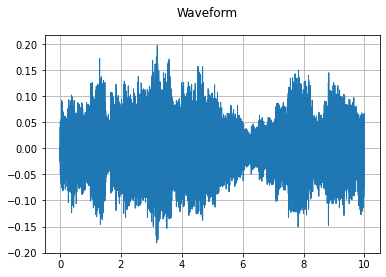

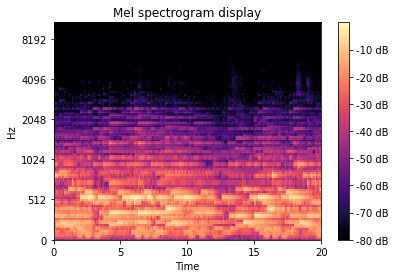

In [ ]:
show_audio(waveform, sample_rate)

Sample Rate: 44100
Shape: (1, 441000)
Dtype: torch.float32
 - Max:      0.197
 - Min:     -0.181
 - Mean:     0.000
 - Std Dev:  0.040

tensor([[ 4.6492e-06, -1.5736e-05, -9.5367e-07,  ...,  2.5197e-02,
          2.6959e-02,  2.8274e-02]])



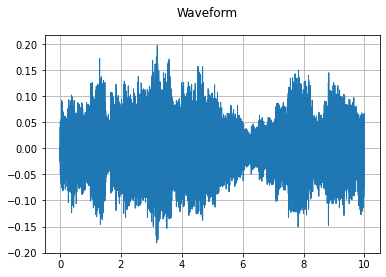

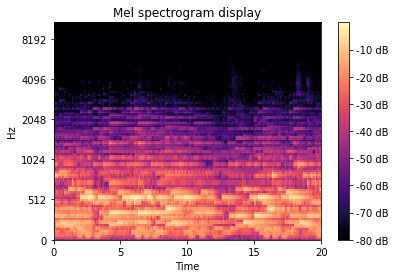

In [ ]:
target, sr_targ = torchaudio.load(fnames_targ[-1])
show_audio(waveform, sr_targ)

Wow those two looked really similar. Let's see the difference:

Sample Rate: 44100
Shape: (1, 441000)
Dtype: torch.float32
 - Max:      0.191
 - Min:     -0.182
 - Mean:     0.000
 - Std Dev:  0.044

tensor([[-0.0002, -0.0002, -0.0002,  ...,  0.0430,  0.0458,  0.0486]])



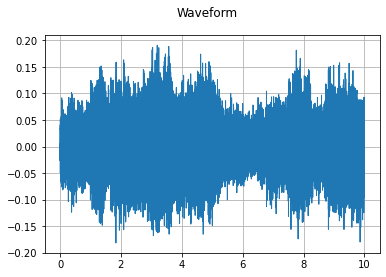

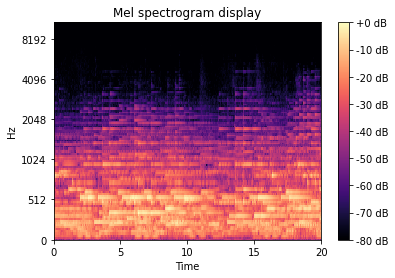

In [ ]:
diff = waveform - target
show_audio(diff, sample_rate)

In [ ]:
#plt.plot(waveform.numpy())
#plt.plot(target.numpy())

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fd27b1914c0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
waveform.size